In [2]:
import yfinance as yf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from torch import nn,tensor,float32,cuda,zeros
from torch import device as torch_device
from torch.utils.data import TensorDataset,DataLoader
from torch.nn import MSELoss
from torch.optim import Adam

In [3]:
device=torch_device("cuda" if cuda.is_available() else "cpu")

Params

In [4]:
windowsize=5

Import Data

In [5]:
stock=yf.download(tickers="NVDA",period="7d",interval="1m",multi_level_index=False,)
stock.drop("Volume",axis="columns",inplace=True)

C:\Users\tejes\AppData\Local\Temp\ipykernel_28128\1468470456.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock=yf.download(tickers="NVDA",period="7d",interval="1m",multi_level_index=False,)
[*********************100%***********************]  1 of 1 completed


In [6]:
stock.head()

,Close,High,Low,Open
Datetime,,,,
2025-10-13 13:30:00+00:00,188.669998,188.990005,187.880005,187.964996
2025-10-13 13:31:00+00:00,188.759995,189.259995,188.350006,188.639999
2025-10-13 13:32:00+00:00,188.755005,189.100006,188.453506,188.744995
2025-10-13 13:33:00+00:00,188.490005,189.141693,188.300003,188.740005
2025-10-13 13:34:00+00:00,187.770004,188.559998,187.750595,188.500000


In [7]:
X=stock[['Close','High','Low']].values
y=stock[['Open']].values

Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
X_scaler=StandardScaler()
y_scaler=StandardScaler()

X_scaled=X_scaler.fit_transform(X)
y_scaled=y_scaler.fit_transform(y)

Train Test Split

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_scaled,train_size=0.8,shuffle=False)

In [11]:
print("X_train Size:",len(X_train))
print("X_test Size",len(X_test))

X_train Size: 2048
X_test Size 513


Sliding Windows

In [12]:
def sliding_windows(x,y,size=4):
    out=[]
    for i in range(len(x)-size):
        out.append(x[i:i+size])
    return np.array(out),y[size:]

In [13]:
X_train_sliding,y_train_sliding=sliding_windows(X_train,y_train,size=windowsize)
X_test_sliding,y_test_sliding=sliding_windows(X_test,y_test,size=windowsize)

Datasets

In [14]:
train_dataset=TensorDataset(tensor(X_train_sliding,dtype=float32),tensor(y_train_sliding,dtype=float32))
test_dataset=TensorDataset(tensor(X_test_sliding,dtype=float32),tensor(y_test_sliding,dtype=float32))

Loaders

In [15]:
train_loader=DataLoader(train_dataset,pin_memory=cuda.is_available(),batch_size=16)
test_loader=DataLoader(test_dataset,pin_memory=cuda.is_available(),batch_size=128)

Model

In [16]:
class LSTM_Model(nn.Module):
    def __init__(self,hidden_units=32,num_layers=1):
        super(LSTM_Model,self).__init__()

        self.hidden_units=hidden_units
        self.num_layers=num_layers

        self.lstm_layer=nn.LSTM(input_size=3,num_layers=num_layers,hidden_size=hidden_units,batch_first=True)
        self.nn_block=nn.Sequential(
            nn.LazyLinear(out_features=64),
            nn.SELU(),
            nn.Linear(64,32),
            nn.SELU(),
            nn.Linear(32,1),
        )
    
    def forward(self,x):
        
        h0=zeros(self.num_layers, x.size(0), self.hidden_units).requires_grad_().to(device)
        c0=zeros(self.num_layers, x.size(0), self.hidden_units).requires_grad_().to(device)
        
        out,_=self.lstm_layer(x,(h0,c0))
        out=out[:, -1, :]
        out = self.nn_block(out)

        return out

In [17]:
model=LSTM_Model(hidden_units=128).to(device)
mse_loss=MSELoss().to(device)
optimizer=Adam(params=model.parameters(),lr=1e-5)

Validation Method

In [18]:
def validate():
    model.eval()
    y_pred=[]

    for idx,(x,y) in enumerate(test_loader):
        x=x.to(device)
        y=y.to(device)

        model.zero_grad()
            
        out=model(x)
        y_pred.extend(list(out.detach().cpu().numpy()))
    
    model.train()

    return r2_score(y_pred=y_pred,y_true=y_test_sliding)

Train

In [19]:
def train(epochs=10):
    
    losses=[]
    model.train()
    for epoch in range(epochs):

        epoch_losses=[]

        for idx,(x,y) in enumerate(tqdm(train_loader)):
            x=x.to(device)
            y=y.to(device)

            model.zero_grad()
            
            out=model(x)

            loss = mse_loss(out, y)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        
        losses.append(np.mean(epoch_losses))
        print(f"Validation R2:{validate()}")
    
    return losses

In [20]:
losses=train(20)

100%|██████████| 128/128 [00:00<00:00, 276.37it/s]


Validation R2:0.03451759842639057


100%|██████████| 128/128 [00:00<00:00, 301.67it/s]


Validation R2:0.0836160251970055


100%|██████████| 128/128 [00:00<00:00, 314.23it/s]


Validation R2:0.13862400754680104


100%|██████████| 128/128 [00:00<00:00, 267.12it/s]


Validation R2:0.19901570459494422


100%|██████████| 128/128 [00:00<00:00, 299.45it/s]


Validation R2:0.2671145721382536


100%|██████████| 128/128 [00:00<00:00, 302.12it/s]


Validation R2:0.34297200903674896


100%|██████████| 128/128 [00:00<00:00, 310.55it/s]


Validation R2:0.42689434714268204


100%|██████████| 128/128 [00:00<00:00, 312.23it/s]


Validation R2:0.5186938657744498


100%|██████████| 128/128 [00:00<00:00, 310.41it/s]


Validation R2:0.6145876529390246


100%|██████████| 128/128 [00:00<00:00, 297.87it/s]


Validation R2:0.7073784728746406


100%|██████████| 128/128 [00:00<00:00, 301.63it/s]


Validation R2:0.7904545741681532


100%|██████████| 128/128 [00:00<00:00, 316.51it/s]


Validation R2:0.8594728025486348


100%|██████████| 128/128 [00:00<00:00, 316.66it/s]


Validation R2:0.911337634498357


100%|██████████| 128/128 [00:00<00:00, 317.68it/s]


Validation R2:0.9465142862882971


100%|██████████| 128/128 [00:00<00:00, 303.40it/s]


Validation R2:0.9674196345916841


100%|██████████| 128/128 [00:00<00:00, 313.49it/s]


Validation R2:0.977339807071946


100%|██████████| 128/128 [00:00<00:00, 300.92it/s]


Validation R2:0.9803800964706392


100%|██████████| 128/128 [00:00<00:00, 304.82it/s]


Validation R2:0.9799852516916073


100%|██████████| 128/128 [00:00<00:00, 308.76it/s]


Validation R2:0.9783922296902451


100%|██████████| 128/128 [00:00<00:00, 313.77it/s]

Validation R2:0.9767390890019324


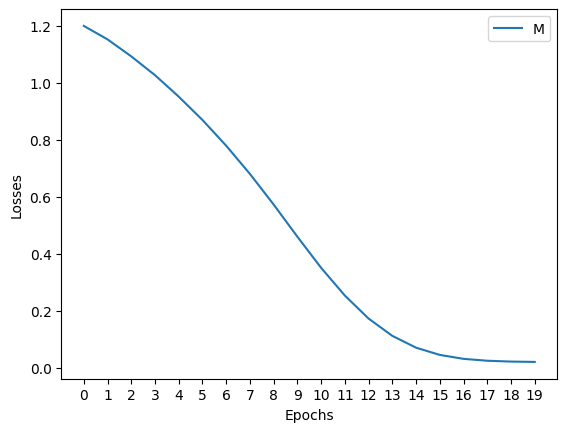

In [21]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend("MSE Loss")
plt.xticks(np.arange(len(losses)))
plt.show()

In [22]:
def test():
    model.eval()
    y_pred=[]

    for idx,(x,y) in enumerate(tqdm(test_loader)):
        x=x.to(device)
        y=y.to(device)

        model.zero_grad()
            
        out=model(x)
        y_pred.extend(list(out.detach().cpu().numpy()))
    
    return y_pred

In [23]:
y_pred=y_scaler.inverse_transform(test())
y_true=y_scaler.inverse_transform(y_test_sliding)

100%|██████████| 4/4 [00:00<00:00, 328.75it/s]


Plotting

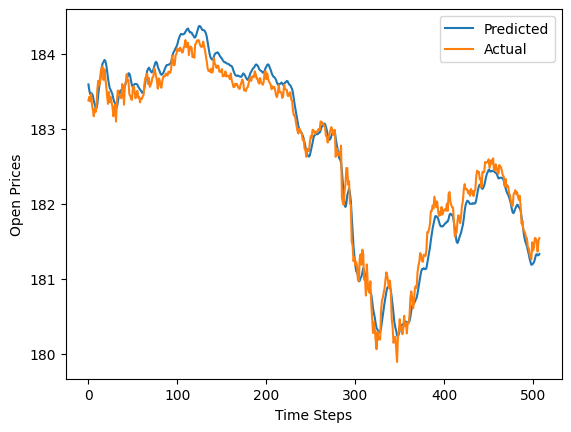

In [24]:
plt.plot(y_pred)
plt.plot(y_true)
plt.xlabel("Time Steps")
plt.ylabel("Open Prices")
plt.legend(['Predicted','Actual'])
plt.show()

In [25]:
print("R2 Score:",r2_score(y_pred=y_pred,y_true=y_true))

R2 Score: 0.9767390890019325
